In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from predictables.util import to_pl_lf
from predictables.univariate import Univariate

# load data
df = load_breast_cancer(as_frame=True).frame
df.columns = [c.replace(" ", "_") for c in df.columns]
df["cv"] = np.random.randint(1, 6, df.shape[0])
df = to_pl_lf(df)

df.head().collect()

mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,cv
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,0,3
20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902,0,2
19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,0,1
11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,0,1
20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678,0,3


In [2]:
df.collect().shape

(569, 32)

### fit each fold to a model

In [3]:
X, y = (
    df.collect().to_pandas().drop(columns="target"),
    df.select("target").collect().to_pandas()["target"],
)
X.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,cv
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,2
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3


In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pd.DataFrame(
    pca.transform(X), columns=[f"comp_{i}" for i in range(1, 3)]
).assign(cv=X["cv"])
X_pca

,comp_1,comp_2,cv
0,1160.142576,-293.917432,3
1,1269.122508,15.631016,2
2,995.794016,39.158436,1
3,-407.180672,-67.378511,1
4,930.341183,189.340686,3
...,...,...,...
564,1414.126686,110.222443,3
565,1045.018919,77.058416,2
566,314.501760,47.553553,3
567,1124.858118,34.129213,3


In [5]:
m = Univariate(
    df=pd.concat([X_pca, y], axis=1),
    fold_col="cv",
    feature_col="comp_1",
    target_col="target",
)
m

<Model(df)>

In [6]:
m.coef

-0.0072724030907387

In [7]:
m.results.round(2)

,coef,pvalues,se,lower_ci,upper_ci,acc_train,acc_test,auc_train,auc_test,f1_train,f1_test,precision_train,precision_test,recall_train,recall_test,mcc_train,mcc_test,logloss_train,logloss_test
fold,,,,,,,,,,,,,,,,,,,
1,-0.01,0.0,0.0,-0.01,-0.01,0.90,0.92,0.89,0.89,0.92,0.94,0.89,0.90,0.96,0.99,0.79,0.82,3.49,2.85
2,-0.01,0.0,0.0,-0.01,-0.01,0.91,0.91,0.89,0.89,0.93,0.93,0.89,0.89,0.96,0.98,0.80,0.81,3.40,3.15
3,-0.01,0.0,0.0,-0.01,-0.01,0.91,0.90,0.89,0.89,0.93,0.92,0.90,0.88,0.97,0.97,0.80,0.80,3.34,3.43
4,-0.01,0.0,0.0,-0.01,-0.01,0.92,0.86,0.90,0.82,0.94,0.90,0.90,0.87,0.98,0.93,0.83,0.68,2.85,5.11
5,-0.01,0.0,0.0,-0.01,-0.01,0.90,0.94,0.87,0.94,0.92,0.95,0.88,0.93,0.97,0.97,0.78,0.88,3.69,2.10
mean,-0.01,0.0,0.0,-0.01,-0.01,0.91,0.91,0.89,0.89,0.93,0.93,0.89,0.89,0.97,0.97,0.80,0.80,3.36,3.36
std,0.00,0.0,0.0,0.00,0.00,0.01,0.03,0.01,0.04,0.01,0.02,0.01,0.02,0.01,0.02,0.02,0.07,0.31,1.11


In [8]:
m.yhat_test

0      0.000217
1      0.000098
2      0.000715
3      0.950789
4      0.001151
         ...   
564    0.000034
565    0.000500
566    0.092190
567    0.000280
568    0.996355
Length: 569, dtype: float64

In [9]:
m.yhat_test.round(0).astype(int).sum()

386

In [10]:
m.yhat_train.round(0).astype(int).sum()

386

In [11]:
m.yhat_train

0      0.000217
1      0.000098
2      0.000715
3      0.950789
4      0.001151
         ...   
564    0.000034
565    0.000500
566    0.092190
567    0.000280
568    0.996355
Length: 569, dtype: float64

In [12]:
m.y_train

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64

In [13]:
m.mcc_test

0.8001232702095267

In [ ]:
m.f1_train

0.9286675639300135

In [ ]:
m.recall_train

0.9663865546218487

In [ ]:
m.mcc_train

0.8001232702095267

In [ ]:
m.X_train

,comp_1
0,1160.142598
1,1269.122494
2,995.793862
3,-407.180803
4,930.341179
...,...
564,1414.126683
565,1045.018879
566,314.501730
567,1124.858114


In [ ]:
from predictables.univariate.src.plots import quintile_lift_plot as qlp
# from importlib import reload
# reload(qlp)


ax = qlp.quintile_lift_plot(m.X_train.iloc[:, 0], m.y_train, m.yhat_train, backend="matplotlib")
plt.show()

ImportError: module quintile_lift_plot not in sys.modules

In [ ]:
feature = m.X_train.iloc[:, 0]
target = m.y_train
feature_name = "comp_1"
target_name = "target"

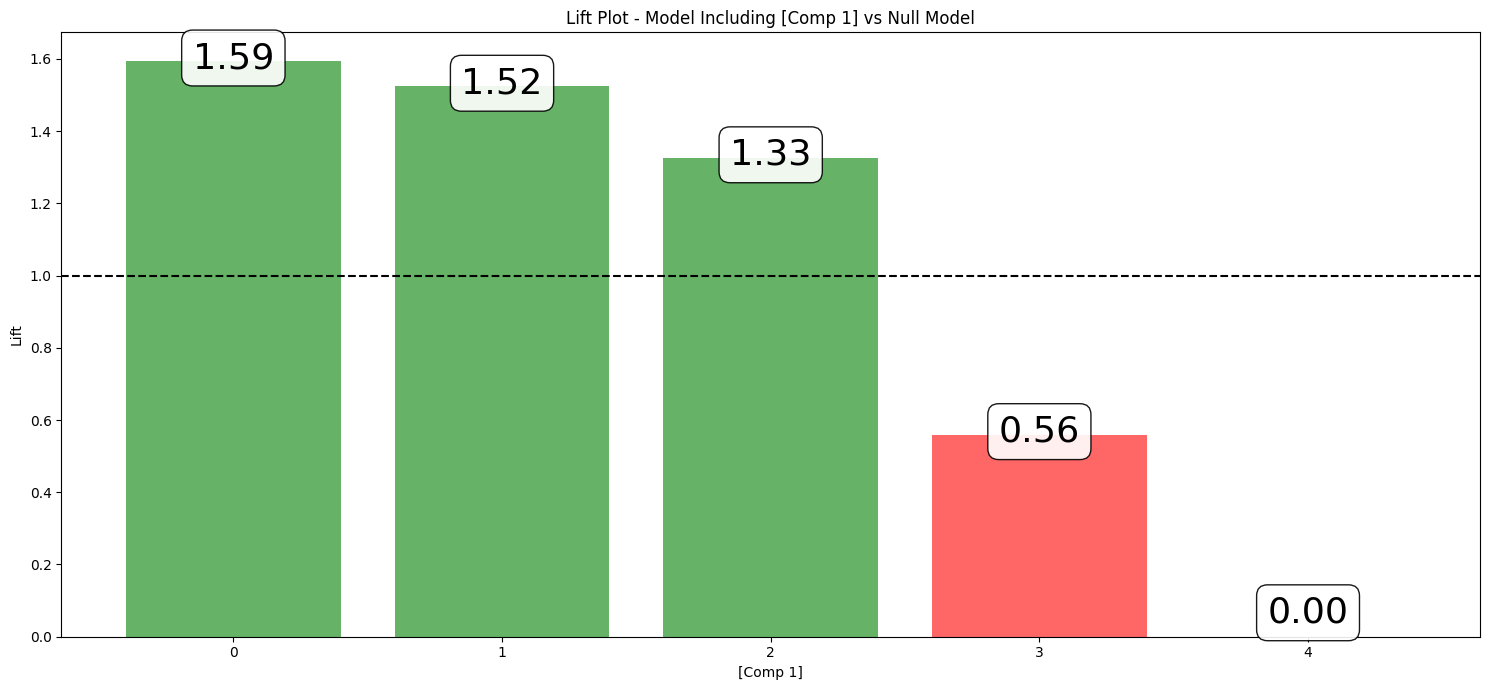

In [ ]:
from predictables.univariate.src.plots._categorical_lift_plot import (
    categorical_lift_plot,
)

feature_quintiles = pd.qcut(feature, 5, labels=False).astype(str).astype("category")

categorical_lift_plot(
    feature_quintiles, target, feature_name, target_name, "matplotlib"
);

In [ ]:
# categorical_lift_plot(feature_quintiles, target, feature_name, target_name, "plotly")

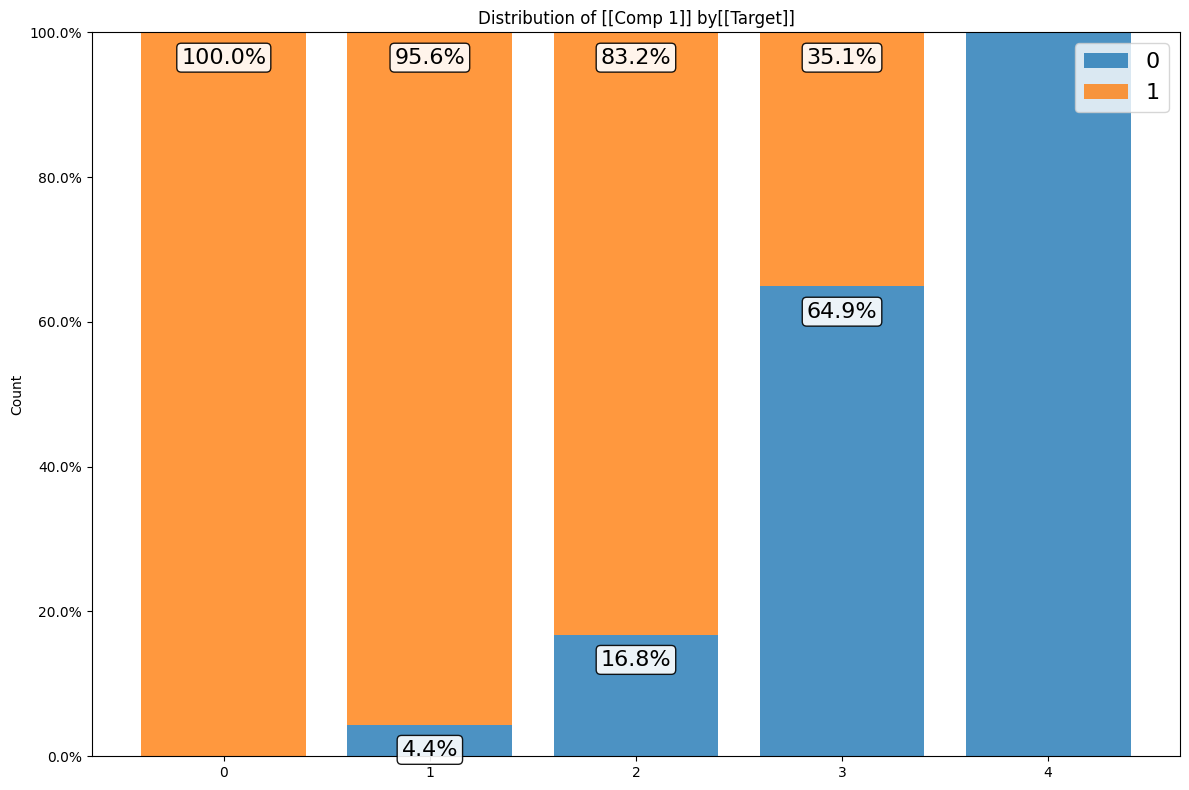

In [ ]:
from predictables.univariate.src.plots._stacked_bar_chart import stacked_bar_chart

stacked_bar_chart(feature_quintiles, target);

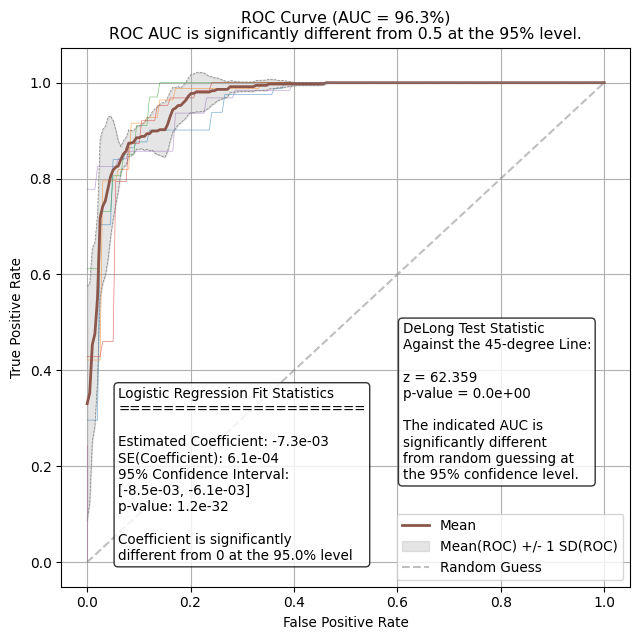

In [ ]:
from predictables.univariate.src.plots._roc_curve_plot import roc_curve_plot

roc_curve_plot(
    m.y_train,
    m.yhat_train,
    m.df.cv,
    figsize=(6.5, 6.5),
    n_bins=200,
    coef=m.coef,
    se=m.se,
    pvalue=m.pvalues,
    cv_alpha=0.6,
);

In [ ]:
from predictables.univariate.src.plots._density_plot import density_plot

ax = density_plot(feature, m.y_train, m.df.cv, figsize=(8, 8), call_legend=True)
plt.show()

NameError: name 'feature' is not defined

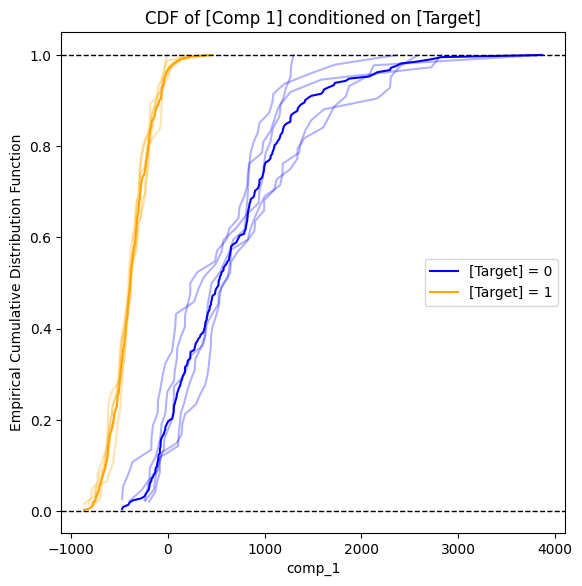

In [ ]:
from predictables.univariate.src.plots._cdf_plot import cdf_plot

cdf_plot(feature, m.y_train, m.df.cv, figsize=(6.5, 6.5));

In [ ]:
m.y_train.name

'target'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


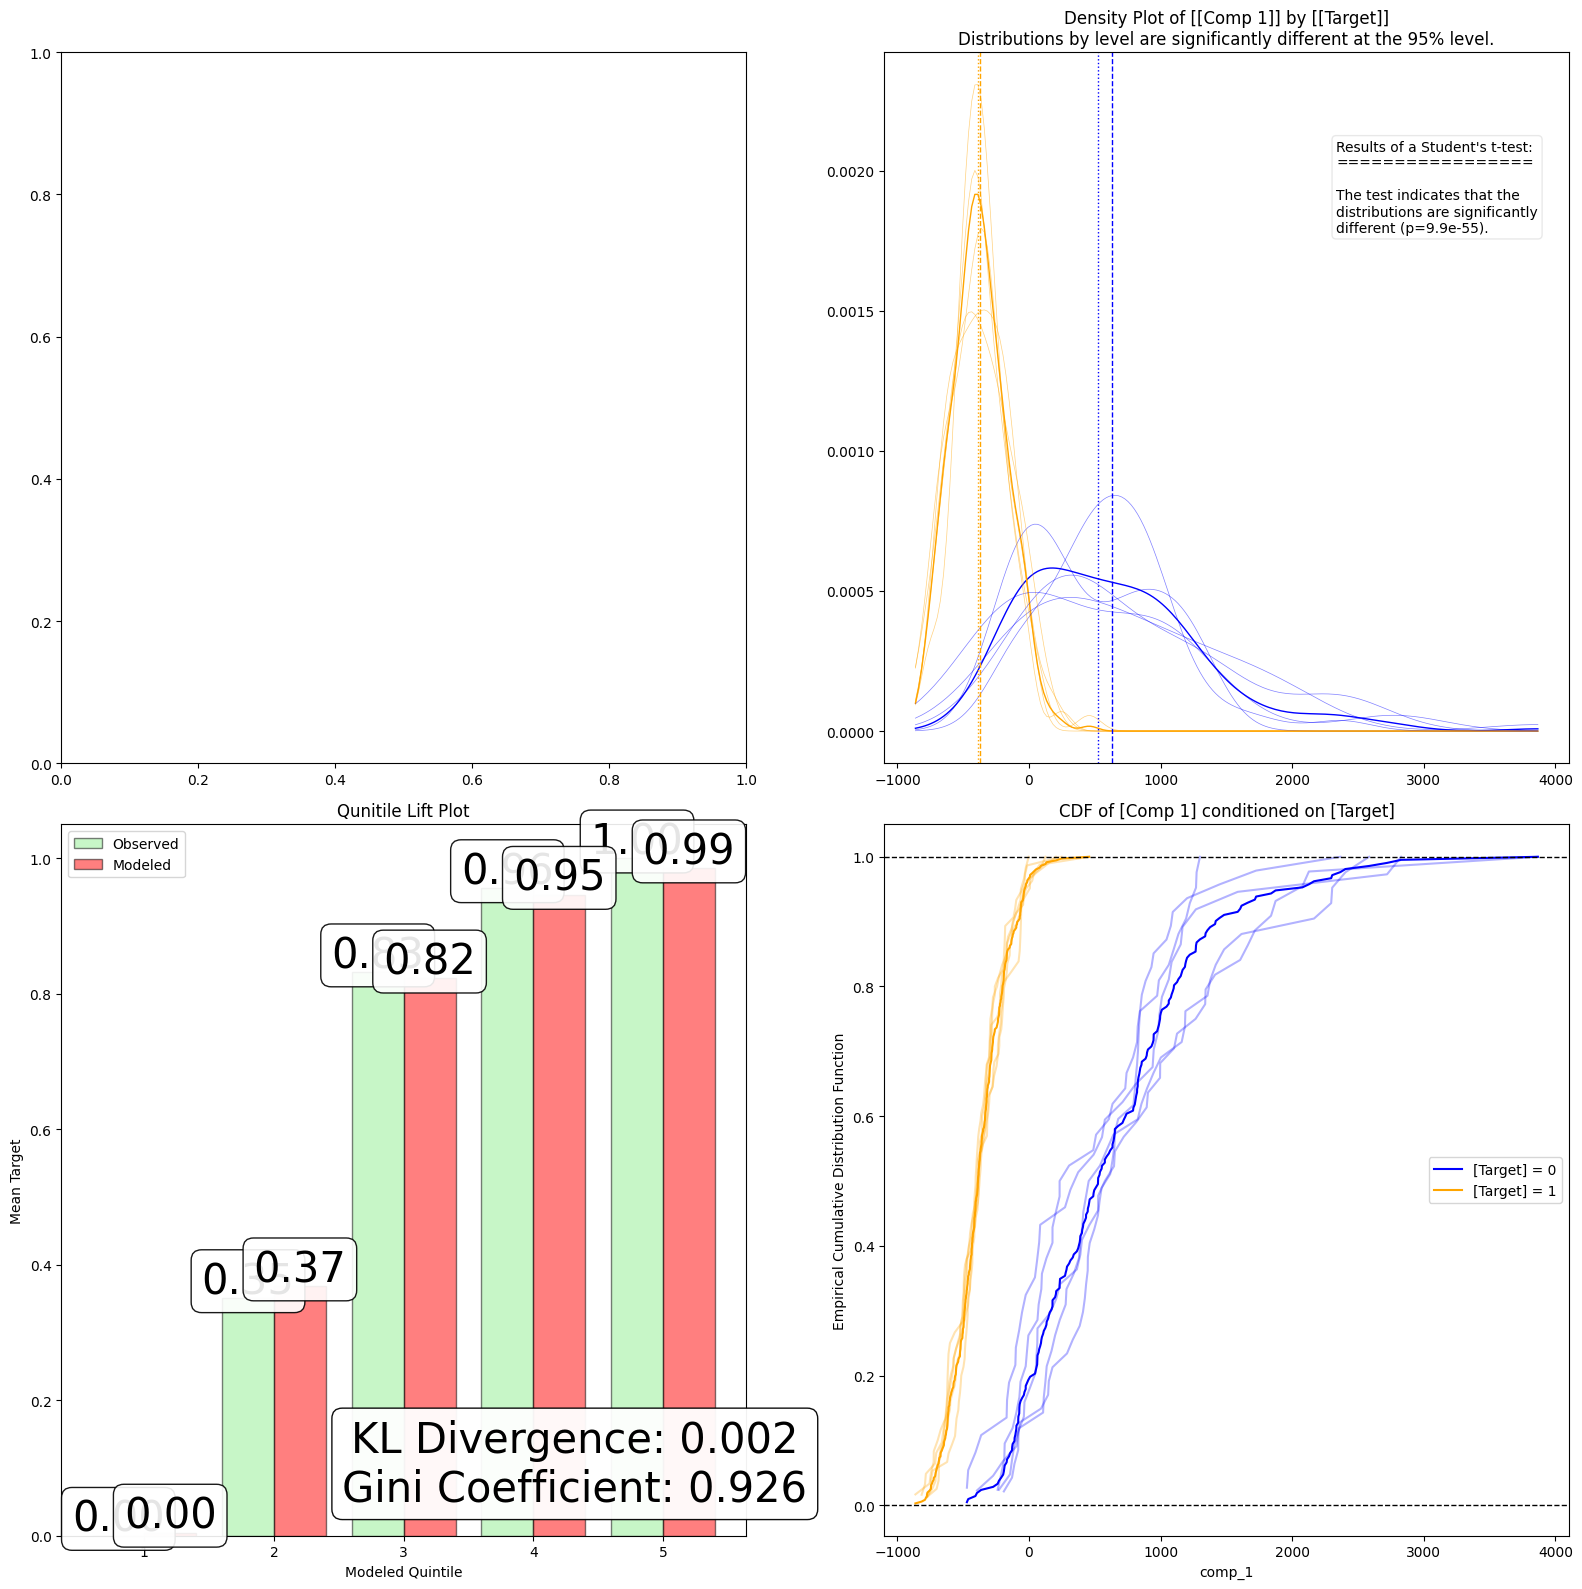

In [ ]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))

# ax1 = roc_curve_plot(
#     m.y_train,
#     m.yhat_train,
#     m.df.cv,
#     n_bins=200,
#     coef=m.coef,
#     se=m.se,
#     pvalue=m.pvalues,
#     cv_alpha=0.6,
#     ax=ax1,
# )
ax2 = density_plot(feature, m.y_train, m.df.cv, call_legend=True, ax=ax2)
ax3 = quintile_lift_plot(
    m.X_train.iloc[:, 0], m.y_train, m.yhat_train, "matplotlib", ax=ax3
)
ax4 = cdf_plot(feature, m.y_train, m.df.cv, ax=ax4)

plt.show()